In [1]:
#import necessary libraries
import pandas as pd
import nltk
import sys # needed this for certain print options during debugging
import numpy as np #lmao why did we not have this before
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/soumyankar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
#load the dataset
from ast import literal_eval
pd.set_option('display.max_colwidth', None)
df = pd.read_csv('data/final_dataset.csv', converters={'ProcessTokens': literal_eval})
#Converting the datatype of processtokens fromm list to string, so that our vectorization works right.
# df['ProcessTokens'] = df['ProcessTokens'].astype("string")
df.head(2)

,review_id,title,tags,year,user_review,user_suggestion,url,Tokens,ProcessTokens,soup
0,1,Spooky's Jump Scare Mansion,"['Action', 'Adventure', 'Free to Play', 'Indie']",2016.0,"I'm scared and hearing creepy voices. So I'll pause for a moment and write a review while I wait for my heart beat to return to atleast somewhat calmer times. This game is adorable and creepy like my happy tree friends but with the graphics sceme of my childhood (but more bubble and 'clean'). Hello 1990's.What charactes there are (that isnot trying to kill me) were likable and a bit odd. I did do a few noob things though, such as:Oh look a class room full of ghosts from dead children, lets shine my flashlight on them and stand there staring at them..Or, hmm creepy music, I'll turn around and see if I can see what's chasing me.Never before in a game have I been this afraid of finding a locked door.",1,https://www.youtube.com/watch?v=48NzbFQebxg,"['I', ""'m"", 'scared', 'and', 'hearing', 'creepy', 'voices', '.', ' ', 'So', 'I', ""'ll"", 'pause', 'for', 'a', 'moment', 'and', 'write', 'a', 'review', 'while', 'I', 'wait', 'for', 'my', 'heart', 'beat', 'to', 'return', 'to', 'atleast', 'somewhat', 'calmer', 'times', '.', ' ', 'This', 'game', 'is', 'adorable', 'and', 'creepy', 'like', 'my', 'happy', 'tree', 'friends', 'but', 'with', 'the', 'graphics', 'sceme', 'of', 'my', 'childhood', '(', 'but', 'more', 'bubble', 'and', ""'"", 'clean', ""'"", ')', '.', ' ', 'Hello', ""1990's"", '.', 'What', 'charactes', 'there', 'are', '(', 'that', 'isnot', 'trying', 'to', 'kill', 'me', ')', 'were', 'likable', 'and', 'a', 'bit', 'odd', '.', ' ', 'I', 'did', 'do', 'a', 'few', 'noob', 'things', 'though', ',', 'such', 'as', ':', 'Oh', 'look', 'a', 'class', 'room', 'full', 'of', 'ghosts', 'from', 'dead', 'children', ',', 'lets', 'shine', 'my', 'flashlight', 'on', 'them', 'and', 'stand', 'there', 'staring', 'at', 'them', '..', 'Or', ',', 'hmm', 'creepy', 'music', ',', 'I', ""'ll"", 'turn', 'around', 'and', 'see', 'if', 'I', 'can', 'see', 'what', ""'s"", 'chasing', 'me', '.', 'Never', 'before', 'in', 'a', 'game', 'have', 'I', 'been', 'this', 'afraid', 'of', 'finding', 'a', 'locked', 'door', '.']","[hearing, creepy, pause, moment, write, review, wait, heart, beat, return, somewhat, calmer, time, game, adorable, creepy, like, happy, tree, graphic, childhood, bubble, clean, hello, trying, kill, likable, bit, odd, oh, look, class, room, dead, shine, flashlight, stand, staring, creepy, music, turn, chasing, game, afraid, finding, locked, door]",hearing creepy pause moment write review wait heart beat return somewhat calmer time game adorable creepy like happy tree graphic childhood bubble clean hello trying kill likable bit odd oh look class room dead shine flashlight stand staring creepy music turn chasing game afraid finding locked door action adventure free to play indie
1,2,Spooky's Jump Scare Mansion,"['Action', 'Adventure', 'Free to Play', 'Indie']",2016.0,"Best game, more better than Sam Pepper's YouTube account. 10/10What you'll need to play:A computerSome extra pants.Pros:Scary as hell.Fun.Adventure.Spooky.Did I forgot to mention that its scary as hell?You'll get more pants/briefs in your wardrobe.Time consuming if you're bored.Cons:Buying pants/briefs. You haven't downloaded it yet.",1,https://www.youtube.com/watch?v=48NzbFQebxg,"['Best', 'game', ',', 'more', 'better', 'than', 'Sam', 'Pepper', ""'s"", 'YouTube', 'account', '.', '10/10What', 'you', ""'ll"", 'need', 'to', 'play', ':', 'A', 'computerSome', 'extra', 'pants', '.', 'Pros', ':', 'Scary', 'as', 'hell', '.', 'Fun', '.', 'Adventure', '.', 'Spooky', '.', 'Did', 'I', 'forgot', 'to', 'mention', 'that', 'its', 'scary', 'as', ""hell?You'll"", 'get', 'more', 'pants', '/', 'briefs', 'in', 'your', 'wardrobe', '.', 'Time', 'consuming', 'if', 'you', ""'re"", 'bored', '.', 'Cons', ':', 'Buying', 'pants', '/', 'briefs', '.', 'You', 'have', ""n't"", 'downloaded', 'it', 'yet', '.']","[best, game, better, sam, pepper, account, need, pla

In [23]:
#JUST FOR FUN :)
#most common words for each category (user_suggestion=1 OR user_suggestion=0)

def words_frequency(data, rating_col, token_col, rating_nr):
    all_rating_tokens = []
    tokens = list(data[data[rating_col] == rating_nr][token_col])
    for i in tokens:
        for j in i:
            all_rating_tokens.append(j)
                
    freq = nltk.FreqDist(all_rating_tokens)
    print(freq.most_common()[0:20])
    freq.plot(10, cumulative=False)
    return freq, all_rating_tokens

[('game', 28458), ('like', 7237), ('play', 6765), ('good', 4889), ('time', 4615), ('fun', 4397), ('early', 4005), ('access', 3939), ('free', 3795), ('nope', 3235), ('great', 3005), ('lot', 2629), ('people', 2616), ('new', 2556), ('want', 2130), ('need', 2113), ('better', 1960), ('best', 1903), ('way', 1868), ('try', 1643)]


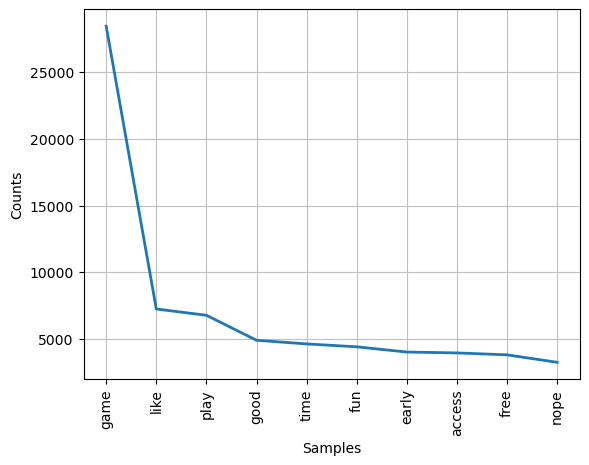

In [24]:
freq, all_rating_tokens = words_frequency(df, 'user_suggestion', 'ProcessTokens', 1)

[('game', 23714), ('play', 5105), ('like', 4795), ('time', 4427), ('good', 3012), ('access', 2963), ('early', 2915), ('money', 2892), ('fun', 2566), ('pay', 2379), ('new', 2264), ('want', 2099), ('people', 2095), ('way', 1685), ('free', 1644), ('bad', 1559), ('need', 1553), ('buy', 1530), ('better', 1513), ('lot', 1345)]


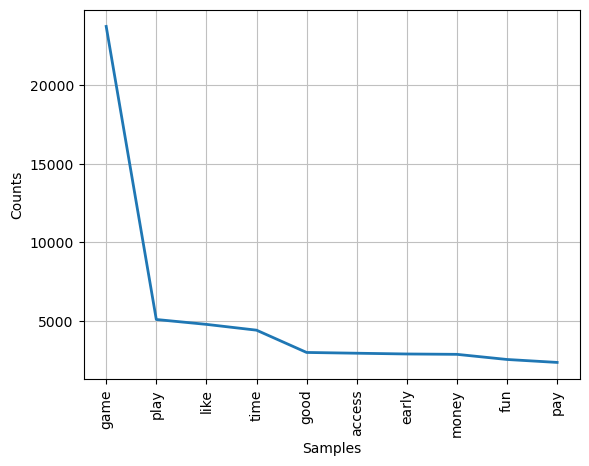

In [25]:
freq, all_rating_tokens = words_frequency(df, 'user_suggestion', 'ProcessTokens', 0)

In [26]:
#Converting the datatype of processtokens fromm list to string, so that our vectorization works right.
df['ProcessTokens'] = df['ProcessTokens'].astype("string")

In [27]:
# train test split before normalization
from sklearn.model_selection import train_test_split

X = df.drop(columns=['user_suggestion','review_id', 'year']).copy()
y = df['user_suggestion']

X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(13995, 7)
(13995,)
(1749, 7)
(1749,)
(1750, 7)
(1750,)


(None, None)

In [28]:
#Check for NaN-Values
print(pd.isna(X_train).values)
print(pd.isna(y_train).values)

[[False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False Fa

In [29]:
#define text vectorizers (I used two different ones, later we can decide which one we should continue with)
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

In [30]:
#text vectorization with count_vectorizer
#vectorization on train_dataset
np.set_printoptions(threshold=sys.maxsize)
def create_vectorized_dataset_count(data):
    list_of_count_vectors = []
    data = data.tolist() # converting to a list
    count_vector = count_vectorizer.fit_transform(data)
    count_array = count_vector.toarray()
#     Uncomment the two lines below to see the count vector with feature names
#     probably might also need to remove print truncation to see the whole thing.
    dftemp = pd.DataFrame(data=count_array,columns = count_vectorizer.get_feature_names())
    #return count_array # this is the 2d
    return count_vector

count_vector = create_vectorized_dataset_count(X_train['ProcessTokens']) # this becomes our count vectorization vector.
# we can use thhis to train our model.


/Users/soumyankar/.pyenv/versions/miniconda3-latest/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [31]:
#text vectorization with tfidf_vectorizer
#vectorization on train_dataset
def create_vectorized_dataset_tfidf(data):
    data = data.tolist()
    tfidf_vector = tfidf_vectorizer.fit_transform(data)
    tfidf_array = tfidf_vector.toarray()
    # prinnting non-zero colummns
    # dftemp = pd.DataFrame(data=tfidf_array, columns=tfidf_vectorizer.get_feature_names())
    # print(dftemp)
    #return tfidf_array
    return tfidf_vector

tfidf_vector = create_vectorized_dataset_tfidf(X_train['ProcessTokens'])

print(tfidf_vector.shape)
#df.head(1)

(13995, 12737)


In [32]:
#transform count test data

test_count_vector = count_vectorizer.transform(X_test['ProcessTokens'])
print("n_samples: %d, n_features: %d" % test_count_vector.shape)

n_samples: 1750, n_features: 12737


In [33]:
#transform tfidf test data

test_tfidf_vector = tfidf_vectorizer.transform(X_test['ProcessTokens'])
print("n_samples: %d, n_features: %d" % test_tfidf_vector.shape)

n_samples: 1750, n_features: 12737


In [34]:
#Naive Bayes with count vector

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(count_vector, y_train)

y_prediction = naive_bayes_classifier.predict(test_count_vector)

print("Multinomial Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_prediction)*100)

Multinomial Naive Bayes model accuracy(in %): 82.22857142857143


In [35]:
# Knn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn_clf = knn.fit(count_vector, y_train)
knn_y_pred = knn_clf.predict(test_count_vector)


print("kNN model accuracy(in %):", metrics.accuracy_score(y_test, knn_y_pred)*100)


kNN model accuracy(in %): 60.68571428571429


In [36]:
# lr
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(count_vector, y_train)
lr_y_pred = lr_clf.predict(test_count_vector)


print("LR model accuracy(in %):", metrics.accuracy_score(y_test, lr_y_pred)*100)

LR model accuracy(in %): 80.57142857142857


/Users/soumyankar/.pyenv/versions/miniconda3-latest/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, lr_y_pred)
from sklearn.metrics import accuracy_score 
print ("Accuracy : ", accuracy_score(y_test, lr_y_pred))

Accuracy :  0.8057142857142857


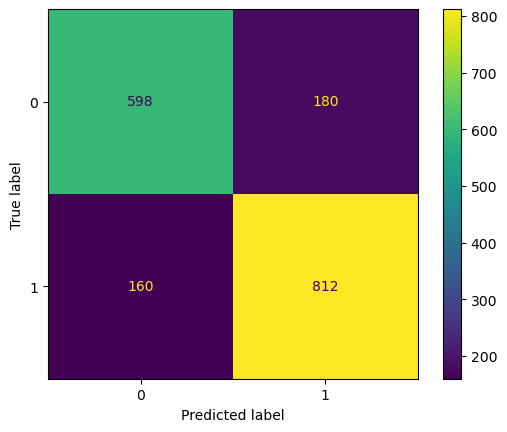

In [38]:
# printing confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lr_clf.classes_)
disp.plot()
plt.show()